In [1]:
import pickle
import emcee
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import getdist
import corner

In [2]:
file = open('F_dec_val.pckl', 'rb')
F_val = pickle.load(file)
file.close()

Edges = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
 5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
 3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
 1.00000000e+06])

E = np.exp(0.5*(np.log(Edges[1:])+np.log(Edges[:-1])))

cfac = 7.66928482E11 # conversion factor for F in units of s^-1 GeV^-2

F_dec = cfac*F_val[0]
F_comb = cfac*F_val[1]
cov_F = cfac**2*F_val[2]
cov_Fcomb = cfac**2*F_val[3]

inv_covF = np.linalg.inv(cov_F)
inv_covFcomb = np.linalg.inv(cov_Fcomb)

F = np.zeros((7,12))
F[0:6] = F_dec[0:6]
F[6] = F_comb

cinvF = np.zeros((7,12,12))
cinvF[0:6] = inv_covF[0:6]
cinvF[6] = inv_covFcomb

covFs = np.zeros((7,12,12))
covFs[0:6] = cov_F[0:6]
covFs[6] = cov_Fcomb



print(inv_covF.shape)
print(inv_covFcomb.shape)
print('F_dec shape:'+ ' ' + str(F_dec.shape))

(6, 12, 12)
(12, 12)
F_dec shape: (6, 12)


In [3]:
## defining functions for F


def power(E,a,F0):
    E0 = 2e4
    return 1e-30*F0*(E/E0)**a

def chi2(theta,E,F_dec,cinv):
    a, F0 = theta
    x = F_dec - power(E,a,F0)
    return -0.5*np.dot(x, np.dot(cinv, x))


def log_prior(theta):
    if (-3 < theta[0] < -1) & (0.01 < theta[1] < 3):
        return 0.0
    return -np.inf

def log_prob(theta,E,F_dec,cinv):
    lprior = log_prior(theta)
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + chi2(theta,E,F_dec,cinv)

In [4]:
nwalkers = 8
ndim = 2
niter = 5000
burn = 300

p0 = [[-2,0.5] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

mcsamples = np.zeros((7,ndim,nwalkers,niter-burn))
flat_samples = np.zeros((7,ndim,nwalkers*(niter-burn)))
for i in range(7):
    sampler = emcee.EnsembleSampler(nwalkers,ndim, lambda theta: log_prob(theta,E,F[i],cinvF[i]))
    pos,prob,state = sampler.run_mcmc(p0, niter, progress = True)
    mcsamples[i] = sampler.get_chain(discard = burn).T
    flat_samples[i] = sampler.get_chain(flat = True, discard = burn).T

100%|██████████| 5000/5000 [00:04<00:00, 1134.26it/s]


0.08151871030882847 -2.1191514785256285
0.11476917013922734 -2.0091014873987185
0.17960489205303065 -1.9704875124787598
0.188526291935032 -2.0878121052517282
0.26914561903973094 -1.9645381514005973
0.3125761169693795 -2.186448459608297
0.1555244675268941 -2.0190163786614383


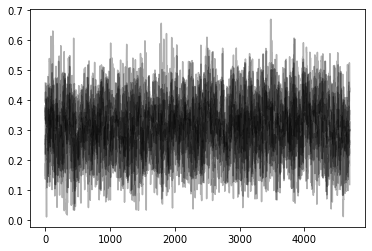

In [17]:
for i in range(7):
    print(np.mean(flat_samples[i,1,:]), np.mean(mcsamples[i,0,:]))

fig, axs = plt.subplots()
plt.plot(mcsamples[5,1,:,:].T,'k', alpha = 0.3)

Text(0, 0.5, 'F0')

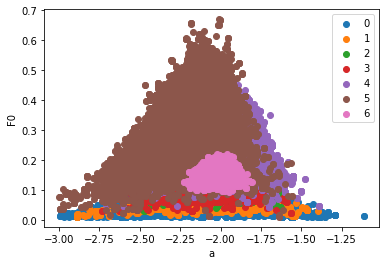

In [6]:
for i in range(7):
    plt.scatter(flat_samples[i,0,:].T,flat_samples[i,1,:].T, marker = 'o' ,label = f'{i}')
plt.legend()
plt.xlabel('a')
plt.ylabel('F0')

Removed no burn in
Removed no burn in


Removed no burn in


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


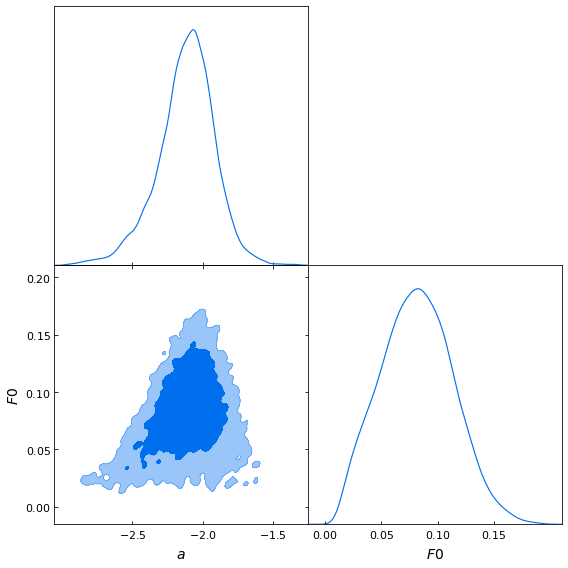

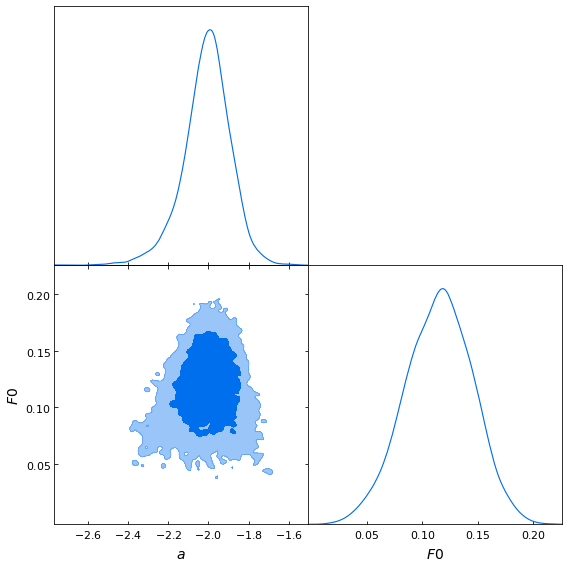

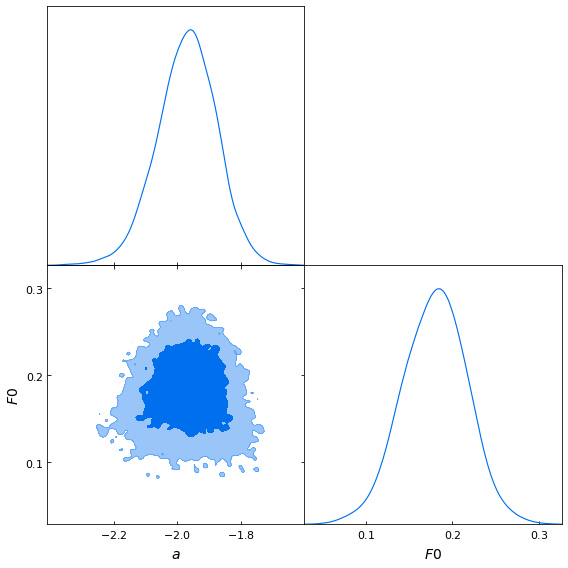

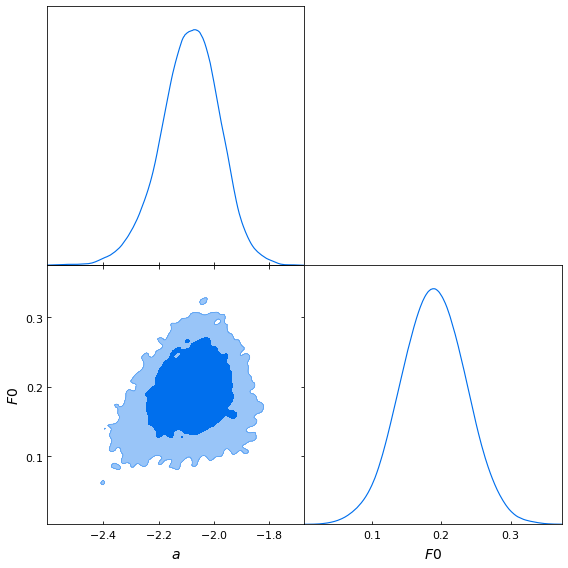

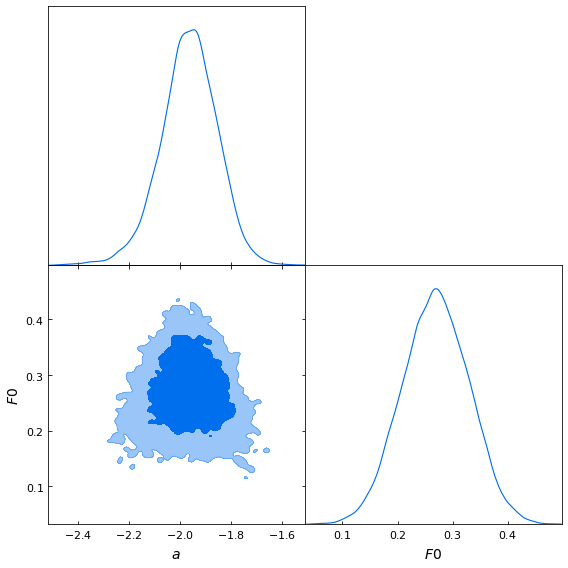

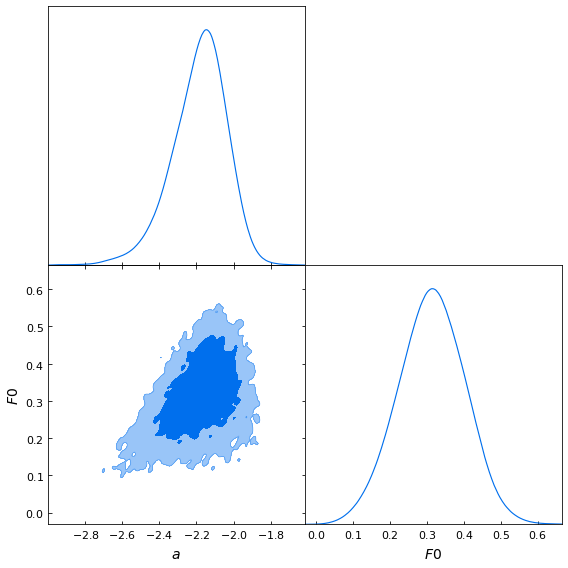

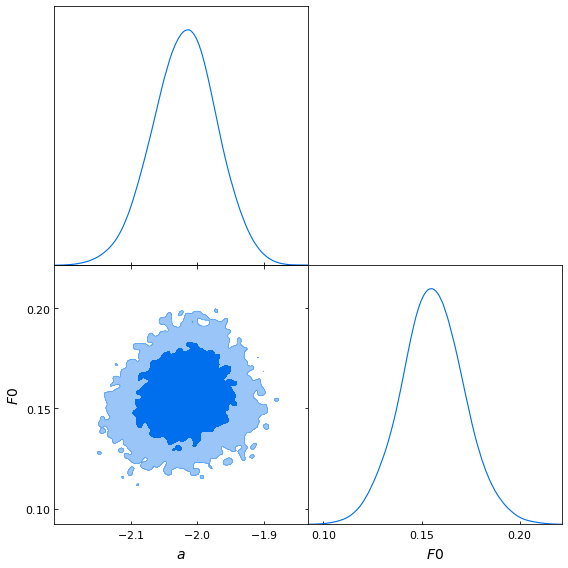

In [18]:
names = ['power index', 'constant']
labels =  ['a', 'F0']
for i in range(7):
    samples = MCSamples(samples= flat_samples[i].T ,names = names, labels = labels)
    g = plots.get_subplot_plotter(subplot_size = 4)
    g.triangle_plot([samples],filled = True)


In [8]:
flat_samples.shape

(7, 2, 37600)

2.5119292308889345
Removed no burn in
3.7382124672071417
Removed no burn in
4.732173327884108
Removed no burn in
3.9952361315289875
Removed no burn in
4.427073868353278
Removed no burn in
3.4558616798560458
Removed no burn in
9.531812435591695
Removed no burn in


<Figure size 432x432 with 0 Axes>

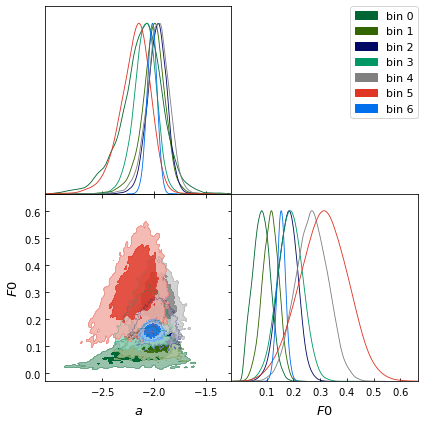

In [9]:
s = []
g = plots.get_single_plotter(ratio = 1, width_inch = 8 )
for i in range(7):
    print(np.mean(flat_samples[i, 1])/np.std(flat_samples[i, 1]))
    samples = MCSamples(samples = flat_samples[i].T, names = names , labels = labels, label = f'bin {i}')
    s.append(samples)
g.triangle_plot(s, filled=True)


In [10]:
def get_constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        print(samples.parLabel(i))
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        print('upper = %.15f' % upper)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        print('lower = %.15f' % lower)
        print('mean = %.15f' %mean)
    return 


for i in range(7):
    samples = MCSamples(samples= flat_samples[i].T ,names = names, labels = labels)
    get_constraints(samples)

Removed no burn in
a
upper = -1.810336777297604
lower = -2.489863793162423
mean = -2.119151478525626
F0
upper = 0.135315952928143
lower = 0.028248835920558
mean = 0.081518710308828
Removed no burn in
a
upper = -1.826961575941274
lower = -2.219906791651468
mean = -2.009101487398716
F0
upper = 0.163609905540041
lower = 0.062787407983285
mean = 0.114769170139228
Removed no burn in
a
upper = -1.820006821638068
lower = -2.129087483279984
mean = -1.970487512478756
F0
upper = 0.239844469299131
lower = 0.116609124173879
mean = 0.179604892053031
Removed no burn in
a
upper = -1.919889736144896
lower = -2.274058820384145
mean = -2.087812105251728
F0
upper = 0.265695591828370
lower = 0.111087785538833
mean = 0.188526291935032
Removed no burn in
a
upper = -1.787997479880168
lower = -2.153385572716534
mean = -1.964538151400589
F0
upper = 0.367670650364201
lower = 0.168922552985589
mean = 0.269145619039730
Removed no burn in
a
upper = -1.964874398111513
lower = -2.455956499449148
mean = -2.1864484596

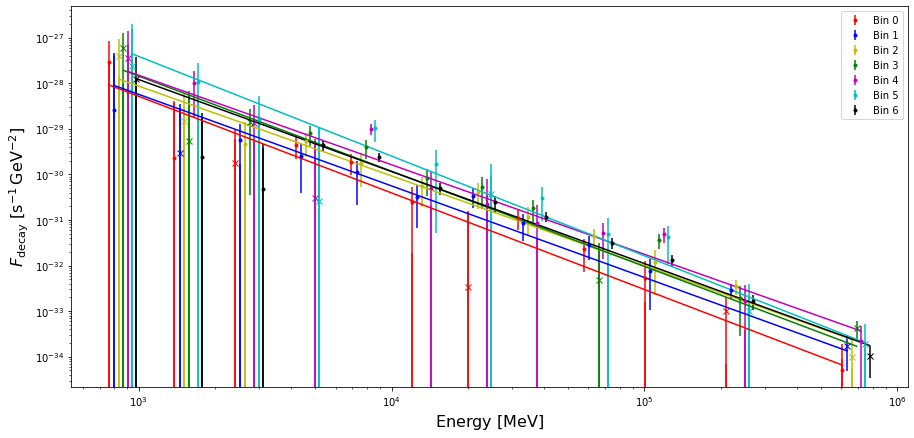

In [11]:
f = plt.figure()
for g, c in enumerate(['r', 'b', 'y', 'g', 'm', 'c', 'k']):
    plt.errorbar(E*(1+0.05*(g+1)), F[g], yerr= np.sqrt(np.diag(covFs[g])), fmt=c +'.', label=f'Bin {g}')
    plt.errorbar(E*(1+0.05*(g+1)), -F[g], yerr = np.sqrt(np.diag(covFs[g])), fmt=c +'x')
    plt.plot(E*(1+0.05*(g+1)), power(E,np.mean(flat_samples[g,0,:]),np.mean(flat_samples[g,1,:])),c)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$F_{\rm decay}\,\,[{\rm s}^{-1}\,{\rm GeV}^{-2}]$', fontsize = 16)
    plt.xlabel('Energy'+ ' '+ r'$[{\rm MeV}]$', fontsize = 16)
    plt.legend()
    
f.set_figwidth(15)
f.set_figheight(7)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Text(0, 0.5, '$F_{\\rm dec}\\,\\,{\\rm s}^{-1}\\,{\\rm GeV}^{-2}]$')

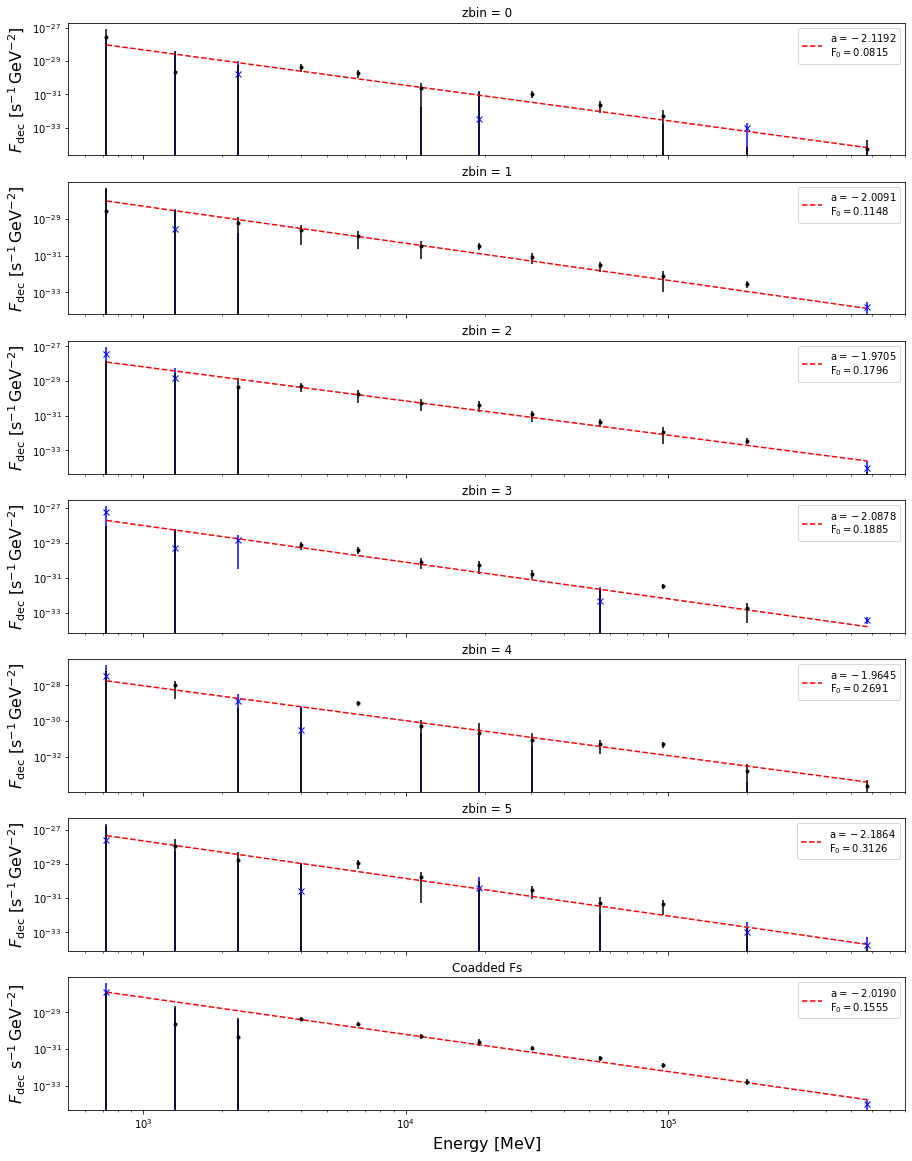

In [14]:
fig, axs = plt.subplots(7, figsize = (15,20), sharex = True)

for i in range(6):
    samples = MCSamples(samples= flat_samples[i].T ,names = names, labels = labels)
    textstr = '\n'.join((
    r'$\mathrm{a} =%.4f$' % (samples.getMeans()[0] , ),
    r'$\mathrm{F}_{0}=%.4f$' % (samples.getMeans()[1], )))
    ax = axs[i]
    ax.errorbar(E,-F[i], yerr = np.sqrt(np.diag(covFs[i])), fmt = 'bx')
    ax.errorbar(E,F[i],yerr = np.sqrt(np.diag(covFs[i])),fmt = 'k.')
    ax.plot(E,power(E,np.mean(flat_samples[i,0,:]),np.mean(flat_samples[i,1,:])), 'r--', label = f'{textstr}')
    ax.set_title(f'zbin = {i}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r'$F_{\rm dec}\,\,[{\rm s}^{-1}\,{\rm GeV}^{-2}]$', fontsize=16)
    ax.legend()
axs[-1].set_xlabel('Energy'+ ' '+ r'$[{\rm MeV}]$', fontsize = 16)
axs[6].errorbar(E,-F[6], yerr = np.sqrt(np.diag(covFs[6])), fmt = 'bx')
axs[6].errorbar(E,F[6],yerr = np.sqrt(np.diag(covFs[6])),fmt = 'k.')

sample6 = MCSamples(samples= flat_samples[6].T ,names = names, labels = labels)
textstr6 = '\n'.join((
    r'$\mathrm{a} =%.4f$' % (sample6.getMeans()[0] , ),
    r'$\mathrm{F}_{0}=%.4f$' % (sample6.getMeans()[1], )))

axs[6].plot(E,power(E,np.mean(flat_samples[6,0,:]),np.mean(flat_samples[6,1,:])), 'r--', label = f'{textstr6}')
axs[6].legend()
axs[6].set_title('Coadded Fs')
axs[6].set_xscale('log')
axs[6].set_yscale('log')
axs[6].set_ylabel(r'$F_{\rm dec}\,\,{\rm s}^{-1}\,{\rm GeV}^{-2}]$', fontsize=16)